This notebook is aimed at summarzing the REPET output at different levels of the nomenclature and to plot this out. Parts of it are really slow.


This is no adapted to myrtle rust genome MRv01

In [40]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt
import json
from ipywidgets import widgets
from IPython.display import display
from sklearn.externals.joblib import Parallel, delayed
import seaborn as sns
import matplotlib
import subprocess

In [41]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    This function expects that the variable genome either ends with primary_v1 and that the 2 second of the _x_x_Sx starts with S.
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        if genome.endswith('primary_v1'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_S[0-9]*_([^;| ]*)'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        if genome.endswith('primary_v1'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_S[0-9]*_([A-Z,a-z,0-9,-]*)'

        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        if genome.endswith('primary_v1'):
            blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_S[0-9]*_([^;| ]*)')

        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [42]:
def blast_hit_gff(_feature, _row8, _id):
    """
    This filter parses the blast hit for REPET_TEs from the new 'ID' column. If no blast hit available returns Pastec ids.
    If the result is blast already the value is simple parse the blast hit.
    SSRs also get SSR
    !!!Requires the three_letter_dict to be defined previously.!!!
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the pastec_cat into the first three letter code
        #the spliting of the 'ID' column needs to be done differently depending on the h or p contigs.
        #h contigs contain one additional '_' in the contig id

        pastec_cat = _id.split('_')[0]
        if 'TE_BLR' in _row8:
            #hit_list = [x.split(';')[3] for x in _row8]
            blast_hit_pattern = r'TE_BLR\w*: (\S*)[ |;]'
            blast_hit_prog = re.compile(blast_hit_pattern)
            TE_match = blast_hit_prog.findall(_row8)
            first_sub_class = ':'.join(TE_match[0][:-1].split(':')[1:])
            if len([x for x in TE_match if first_sub_class in x]) == len(TE_match):
                if ';' in first_sub_class:
                    return first_sub_class.split(';')[0]
                else:
                    return first_sub_class
#fix this here to include the there letter code of the first bit of the ID similar to the blast hits
#e.g. ClassI:?:? and so on. a dict might be the easiest here.
            
            else:
                return three_letter_dict[pastec_cat]
        else:
            return three_letter_dict[pastec_cat]
    if _type == 'REPET_SSRs':
        return 'SSR'
        

        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        return ':'.join(_id.split(':')[1:])

In [43]:
def TE_classification_filter(_id, level = 0):
    """
    This function pulls out the class == level1, Order == level2, Superfamily == leve3.
    If SSR or noCat return these values.
    
    """
    if len(_id.split(':')) == 1:
        return _id
    if level == 0:
        _class = _id.split(':')[0]
        if _class == 'ClassI':
            return 'Retrotransposon'
        if _class == 'ClassII':
            return 'DNA_transposon'
    elif level == 1:
        _order = _id.split(':')[1]
        if _order == '?':
            return 'noCat'
        else:
            return _order
    elif level == 2:
        _superfamily = _id.split(':')[2]
        if _superfamily == '?':
            return 'noCat'
        else:
            return _superfamily
    else:
        print('Something wrong! Check if level is 0, 1 or 2')

In [44]:
# subset the id and safe in specific folder
# return the subsetted file as bedtool
def subset_id(_id, bed_fh, repet_prefix, genome_file_fh):
    '''A function that takes the a ID, e.g. from the ID column 9 of a gff,
    a bed file handle, e.g. the gff frame, a certain file prefix, and a genome_file handle.
    It saves out the coverage file and the gff file for the specific ID.'''
    #ClassI are retrotransposon form blast
    if 'ClassI:' in _id:
        out_path = TE_path_dict['Retrotransposon']   
    #ClassII are DNA_transponson
    elif 'ClassII' in _id:
        out_path = TE_path_dict['DNA_transposon'] 
    #The rest with '_' should be REPET_TEs
    elif _id == 'noCat':
        out_path = TE_path_dict['noCat']
    #everything without '_' at the end should be SSR
    elif _id == 'SSR':
        out_path = TE_path_dict['SSR']
    cov_fh = os.path.join(out_path,'%s.%s.cov' %(repet_prefix,_id))
    gff_fh = cov_fh.replace('.cov', '.gff')
    result = pybedtools.BedTool(bed_fh).filter(id_filter, _id).saveas(gff_fh)
    result.genome_coverage(dz=True,g=genome_file_fh).saveas(cov_fh)
    print('Done with callculating coverage of %s.'% _id)

In [45]:
# Next, we create a function to pass only features for a particular
# featuretype.  This is similar to a "grep" operation when applied to every
# feature in a BedTool
def id_filter(feature, _id):
    if feature[8] == _id:
        return True
    return False

In [46]:
def concatfiles(out_fn, filenames):
    with open(out_fn, 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)

In [47]:
def samcov_slurp(file_name, mean=False, fil=True):
    """
    Function that slurps in the the file via the file_name and tests if looks a samcov file.
    If this is the case it makes a dataframe out of the samcov file and calculates the following values.
    Ave_cov per window, which is the average coverage for each genomic interval. 
    Norm_cov per window, is the normalized coverage for each genomic interavl. This
    can be either calculated by via the mean coverage of the dataframe or via a provided mean.
    """
    if file_name.endswith('.samcov') == False:
        print("%s Might not be a samcov file. Please check" % file_name)
        return False
        
    samcov_header_bed_3 = ['contig', 'start', 'stop', 'total_cov']
    samcov_header_bed_6 = ['contig', 'start', 'stop', 'ID', 'score', 'strand','total_cov']
    df = pd.read_csv(file_name, sep='\t', header=None)
    if len(df.columns) == 4:
        df.rename(columns=dict(zip(df.columns, samcov_header_bed_3)), inplace=True)
    elif len(df.columns) == 7:
        df.rename(columns=dict(zip(df.columns, samcov_header_bed_6)), inplace=True)
    else:
        print("%s Might not be a samcov file. Please check" % file_name)
        return False
    
    df['interval_size'] = (df.stop-df.start)
    df['ave_cov'] = df.total_cov/df['interval_size']
    if mean == False:
        df_mean = sum(df.total_cov)/sum(df.interval_size)
        df['norm_cov'] = df['ave_cov']/df_mean
    else:
        df['norm_cov'] = df['ave_cov']/mean
    #rounder = pd.Series([0,0,0,0,2], index = df.columns)
    df.ave_cov = df.ave_cov.round()
    if fil == True:
        low = 0 #these were defined empirical based on the iqr caculations using 0.01 
        high = 400 #and 0.99 as cut off.
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    return df

In [48]:
def run_samtools_bedcov(window_bed_fn, bam_fn, output_fh):
    """Runs samtools bedcov as a subprocess so we can paralize the different runs saving some time.
    Input: 
    The window_bed fn for which the samtools bedcov should be calculated.
    The bam_fn file that contains the read mapping.
    The output_fn where the output is saved to.
    These should be absolute path"""
    cmd = r'samtools bedcov %s %s > %s' % (window_bed_fn, bam_fn,output_fh)
    stderr = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)
    print('Done with %s' % cmd)

In [49]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

### Description
This notebook runs on myrtle rust genome MR_v01. The repeat database was 
MR_P2A_300Mb_denovoLibTEs_filtered_Blastclust.fa which was produced by running TEdenovo on a subsampled genome of 300Mb of the unscaffolded genome. The classif_table in the SQL was MR_P2A_300Mb_consensus_classif.

All REPET gff files got combined as follows using the the naming convention GENOME.DENOVODATABASE.REPET.gff.  

The local folder for this analysis is .


APSI_primary_v1.MR_P2A_300Mb.REPET.gff3

### Change following input here.

In [50]:
source_dir = '../../../genome_v03/genome/'
genome = 'APSI_primary_v1'
#in case the genome version for the REPET run had a different ID.
genome_repet = 'MR_P2_a0'
Tenovodb = 'MR_P2A_300Mb'
out_dir = '../../TE_analysis/'
repet_db_dir = '../../../../databases/REPET/'
#This needs to be updated here according to genome
TE_postanalysis_dir = '../../../genome_v03/REPET/TEannot/primary'
#...
input_dir = '../../REPET/TEannot/primary/MR_P2_a0_GFF3chr/'
#threads to use for multithreading
threads = 8

In [51]:
##OUTPATH for figures
OUTPATH='../../figures/'

In [52]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [53]:
###here are some input files for the mapping rate coverage analysis using SRM
genome_fh = os.path.join(source_dir, '%s.fa' %genome)
genome_file_fh = os.path.join(source_dir, '%s.genome_file' %genome)
TE_gff_fh = os.path.join(out_dir,'%s.%s.REPET.gff3' % (genome, Tenovodb))

In [54]:
#now generate the genmoe files if not present yet
if not os.path.exists(genome_file_fh):
    !samtools faidx {genome_fh}
    !cat {genome_fh}.fai | sort -k1,1n | cut -f 1,2 > {genome_file_fh}

In [55]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {input_dir}/{genome}.{Tenovodb}.REPET.gff3 > {out_dir}/{genome}.{Tenovodb}.REPET.gff3

In [56]:
os.path.join(out_dir, '%s.%s.REPET.gff3'%(genome,Tenovodb))

'../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET.gff3'

In [57]:
#read in repet_gff file
repet_gff = pd.read_csv(os.path.join(out_dir, '%s.%s.REPET.gff3'%(genome,Tenovodb)), sep='\t', header=None)

In [58]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [59]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [60]:
!ls {TE_postanalysis_dir}

blastclust.log
error.log
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthCopy.fa
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthCopy.txt
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthFrag.fa
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_FullLengthFrag.txt
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_OneCopyAndMore.fa
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE_OneCopyAndMore.txt
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab
MR_P2_a0_chr_allTEs_nr_noSSR_join_path.globalAnnotStatsPerTE.txt
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_FullLengthCopy.fa
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_FullLengthCopy.txt
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_FullLengthFrag.fa
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_FullLengthFrag.txt
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_OneCopyAndMore.fa
MR_P2_a0_chr_allTEs_path.annotStatsPerTE_OneCopyAndMore.txt
MR_P2_a0_chr_allTEs_path.annotStatsPerTE.tab
MR_P2_a0

In [61]:
#this needs to be fixed up to pick the proper summary table
#this reads in the REPET summary dataframe
REPET_sdf = pd.read_csv(os.path.join(TE_postanalysis_dir,\
                    '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                        names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )
#this pulls out the TE classificaiton from the TE column
REPET_sdf['Code'] = REPET_sdf['TE'].apply(lambda x: x.split('_')[0])
code_keys = REPET_sdf['Code'].unique()
code_keys.sort()


In [62]:
#load the previous code_dict from file in the repet database folder
with open(os.path.join(repet_db_dir, 'code_dict.dict'), 'r') as file:
    code_dict = json.loads(file.read())

In [63]:
#now check if all code keys to long classifications are already in the dict
#if this isn't the case get the missing keys
execute_cell = False
if set(code_keys).issubset(set(code_dict.keys()))  == False:
    execute_cell = True
    missing_keys = []
    for x in code_keys:
        if x not in code_dict.keys():
            missing_keys.append(x)
            print('Please add the following key value pair to the dictionary and save it out: %s'%x)  

In [64]:
#now get some user input for the missing code: long namenclature pairing via a widget
dict_parings = 'Nothing new'
if execute_cell == True:
    dict_parings = widgets.Text()
    print('These are the new required additions to the dictionary\n\n')
    print(missing_keys)
    print('Please enter as key:value, key:value') #define how the widget should be filled
    ##TO DO, write a test for this being entered correctly###
    print('\n\n')
    print(code_dict)
else:
    print(dict_parings)

Nothing new


In [65]:
#dict_parings = {'DMX-incomp-chim' : 'DNA_transposon Maverick', 'RIX-comp-chim': 'Retrotransposon LINE'}

In [66]:
#now add the new key: value pair to the dictionary
if dict_parings != 'Nothing new':
    code_dict.update(dict_parings)
    print("Updating the code_dict")
    with open(os.path.join(repet_db_dir, 'code_dict.dict'), 'w') as file:
        file.write(json.dumps(code_dict))

In [67]:
#quick summary for each category based on the REPET summary dataframe
REPET_sdf['Code long'] = REPET_sdf['Code'].apply(lambda x: code_dict[x])
REPET_sdf_sum_df = pd.pivot_table(REPET_sdf, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)
REPET_sdf_mean_df = pd.pivot_table(REPET_sdf, values='length', index='Code long', aggfunc=np.mean)
print('quick summary for each category based on the REPET summary dataframe')
pd.concat([REPET_sdf_sum_df,REPET_sdf_mean_df], axis=1 )

quick summary for each category based on the REPET summary dataframe


,copies,covg,length
Code long,,,
DNA_transposon Helitron,1052,1130454,13225.500000
DNA_transposon MITE,452,146177,606.900000
DNA_transposon Maverick,11,459,12548.000000
DNA_transposon TIR,94989,140876202,9335.903226
DNA_transposon noCat,1018,1003818,8431.000000
Potential Host Gene,797,392965,4796.500000
Retrotransposon DIRS,17159,30208064,10018.401099
Retrotransposon LARD,29257,19080893,5835.588571
Retrotransposon LINE,2085,1933968,3673.809524


In [68]:
#now read in all actuall REPET GFF file
REPET_gff_df = pd.read_csv(os.path.join(out_dir,'%s.%s.REPET.gff3' % (genome, Tenovodb))\
                           , sep='\t', header = None)
#filter out host genes
REPET_gff_df = REPET_gff_df[~REPET_gff_df[8].str.contains("Potential")]

In [69]:
REPET_gff_df.head()

,0,1,2,3,4,5,6,7,8
0,ApsiP_S0001,MR_P2_a0_REPET_TEs,match,97828741,97830112,0.0,-,.,ID=ms524288_ApsiP_S0001_RLX-incomp-chim_Blc450...
1,ApsiP_S0001,MR_P2_a0_REPET_TEs,match_part,97828741,97830112,0.0,-,.,ID=mp524288-1_ApsiP_S0001_RLX-incomp-chim_Blc4...
2,ApsiP_S0001,MR_P2_a0_REPET_TEs,match,97895266,97896251,0.0,+,.,ID=ms524289_ApsiP_S0001_RLX-comp-chim_Blc462_M...
3,ApsiP_S0001,MR_P2_a0_REPET_TEs,match_part,97895266,97896251,0.0,+,.,ID=mp524289-1_ApsiP_S0001_RLX-comp-chim_Blc462...
4,ApsiP_S0001,MR_P2_a0_REPET_TEs,match,97910753,97910863,0.0,-,.,ID=ms524290_ApsiP_S0001_RLX-comp-chim_Blc479_M...


In [70]:
REPET_gff_df['ID'] = REPET_gff_df.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [71]:
code_keys_gff = REPET_gff_df[REPET_gff_df[1].str.contains('REPET_TE')]['ID'].unique()
code_keys_gff = list({x.split('_')[0] for x in code_keys_gff})
three_letter_code = list({x for x in code_keys_gff})
three_letter_code.sort()
three_letter_values = []
for x in three_letter_code:
    if 'MITE' in x:
        _value = "ClassII:MITE:?"
        three_letter_values.append(_value)
        continue
    if 'LARD' in x:
        _value = 'ClassI:LARD:?'
        three_letter_values.append(_value)
        continue
    if 'TRIM' in x:
        _value = 'ClassI:TRIM:?'
        three_letter_values.append(_value)
        continue
    _value =''
    if x[0] == 'D':
        _value = _value + 'ClassII:'
    if x[0] == 'R':
        _value = _value + 'ClassI:'
    if x[0] != 'D' and x[0] != 'R':
        _value = 'noCat'
        three_letter_values.append(_value)
        continue
    if x[1] == 'T':
        _value = _value + 'TIR:?'
    if x[1] == 'H':
        _value = _value + 'Helitron:?'
    if x[1] == 'M':
        _value = _value + 'Maverick:?'
    if x[0:2] == 'DY':
        _value = _value + ':Crypton:?'
    if x[1] == 'X':
        _value = _value + '?:?'
    if x[1] == 'I':
        _value = _value + 'LINE:?'
    if x[1] == 'L':
        _value = _value + 'LTR:?'
    if x[1] == 'P':
        _value = _value + 'Penelope:?'
    if x[1] == 'S':
        _value = _value + 'SINE:?'
    if x[0:2] == 'RY':
        _value = _value + 'DIRS:?'    
    three_letter_values.append(_value)

if len(three_letter_code) == len(three_letter_values):
    print("Aas")
    three_letter_dict = dict(zip(three_letter_code, three_letter_values))

Aas


In [72]:
#this three letter dict is required for the blast_hit_gff function to work and needs to be generated
three_letter_dict

{'DHX-incomp': 'ClassII:Helitron:?',
 'DHX-incomp-chim': 'ClassII:Helitron:?',
 'DMX-incomp-chim': 'ClassII:Maverick:?',
 'DTX-comp': 'ClassII:TIR:?',
 'DTX-comp-chim': 'ClassII:TIR:?',
 'DTX-incomp': 'ClassII:TIR:?',
 'DTX-incomp-chim': 'ClassII:TIR:?',
 'DXX': 'ClassII:?:?',
 'DXX-MITE': 'ClassII:MITE:?',
 'DXX-MITE-chim': 'ClassII:MITE:?',
 'RIX-comp-chim': 'ClassI:LINE:?',
 'RIX-incomp': 'ClassI:LINE:?',
 'RIX-incomp-chim': 'ClassI:LINE:?',
 'RLX-comp': 'ClassI:LTR:?',
 'RLX-comp-chim': 'ClassI:LTR:?',
 'RLX-incomp': 'ClassI:LTR:?',
 'RLX-incomp-chim': 'ClassI:LTR:?',
 'RSX-incomp': 'ClassI:SINE:?',
 'RXX': 'ClassI:?:?',
 'RXX-LARD': 'ClassI:LARD:?',
 'RXX-LARD-chim': 'ClassI:LARD:?',
 'RXX-TRIM': 'ClassI:TRIM:?',
 'RXX-TRIM-chim': 'ClassI:TRIM:?',
 'RXX-chim': 'ClassI:?:?',
 'RYX-incomp-chim': 'ClassI:DIRS:?',
 'XXX-chim': 'noCat',
 'noCat': 'noCat'}

In [73]:
REPET_gff_df['Class:Order:Superfamily'] = REPET_gff_df.apply(lambda row: blast_hit_gff(row[1], row[8], row['ID']), axis=1)

In [74]:
#generate a dict that can be used to rename the Class:Order:Superfamily column 
#considering that partial matches ([2] == match_part) might contain different
#IDs even though they are the same TE only partial.
_tmp_subset = REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

TE_COS_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

_tmp_subset = REPET_gff_df[REPET_gff_df[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

_tmp_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

TE_COS_dict.update(_tmp_dict)
#remove all backslashes from the values as this will conflict with the output later on
for x in TE_COS_dict.keys():
    if '/' in TE_COS_dict[x]:
        value = TE_COS_dict[x]
        print(value)
        TE_COS_dict[x] = value.replace('/','_')
        print(TE_COS_dict[x])

ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD
ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD
ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD
ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD


In [75]:
REPET_gff_df.to_csv(os.path.join(out_dir,'%s.%s.REPET.long.df' % (genome, Tenovodb)),
                    sep='\t', header = None, index=None )

In [76]:
REPET_gff_df['Class:Order:Superfamily'] = REPET_gff_df['ID'].apply(lambda x: TE_COS_dict[x])

In [77]:
print('These are the unique Class:Order:Superfamily classifiers of this dataframe:')
print(REPET_gff_df['Class:Order:Superfamily'].unique())

These are the unique Class:Order:Superfamily classifiers of this dataframe:
['ClassI:LTR:?' 'ClassI:LTR:Gypsy' 'ClassI:LARD:?' 'ClassII:TIR:?'
 'ClassII:TIR:MuDR' 'ClassI:TRIM:?' 'ClassI:LTR:Copia'
 'ClassII:TIR:PIF-Harbinger' 'ClassII:TIR:CACTA' 'noCat' 'ClassII:?:?'
 'ClassII:TIR:hAT' 'ClassII:TIR:Tc1-Mariner' 'ClassII:Helitron:?'
 'ClassII:MITE:?' 'ClassI:LINE:I' 'ClassI:LINE:?' 'ClassI:SINE:?'
 'ClassI:DIRS:?' 'ClassI:?:?' 'ClassII:?:Ginger2_TDD' 'ClassII:Maverick:?'
 'SSR' 'ClassI:LTR:ERV' 'ClassI:DIRS:DIRS' 'ClassII:?:Ginger1'
 'ClassII:Helitron:Helitron' 'ClassI:LTR:Retrovirus' 'ClassI:LINE:Jockey'
 'ClassII:TIR:P' 'ClassI:LINE:RTE' 'ClassI:LTR:Bel-Pao' 'ClassII:?:Novosib'
 'ClassI:LINE:R2' 'ClassII:?:Sola' 'ClassII:TIR:PiggyBac'
 'ClassII:Maverick:Maverick' 'ClassII:?:Kolobok' 'ClassII:Crypton:Crypton'
 'ClassI:LINE:L1' 'ClassII:TIR:Transib' 'ClassI:PLE:Penelope'
 'ClassI:SINE:5S']


In [78]:
#have a rough summary of the coverage not considering overlaps.
REPET_gff_df.drop_duplicates(subset=[3,4,'ID'], inplace =True) 
#this drops all duplicates in the df that completey overlap and have the same ID. Avoid double counting.
REPET_gff_df['Length'] = REPET_gff_df[4] - REPET_gff_df[3]
REPET_gff_df['Class'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
REPET_gff_df['Order'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
REPET_gff_df['Superfamily'] = REPET_gff_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)
REPET_gff_df_COS = REPET_gff_df.groupby(by=['Class','Order','Superfamily'])['Length'].sum()
REPET_gff_df_S = REPET_gff_df.groupby(by=['Class:Order:Superfamily'])['Length'].sum()

In [79]:
print("This is the summary of overlapping coverage according to Class, Order, Superfamily")
print(REPET_gff_df_COS)

This is the summary of overlapping coverage according to Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton                4894
                 Helitron  Helitron            1995908
                           noCat               2353334
                 MITE      noCat                150020
                 Maverick  Maverick                 26
                           noCat                   391
                 TIR       CACTA              67026856
                           MuDR               37020363
                           P                     36204
                           PIF-Harbinger      29781109
                           PiggyBac               5601
                           Tc1-Mariner         7439463
                           Transib                 236
                           hAT                 7042927
                           noCat             151748193
                 noCat     Ginger1              185

In [80]:
print("This is the summary of unqiue TE insertions for each Class, Order, Superfamily")
print(REPET_gff_df.groupby(by=['Class','Order','Superfamily'])['Length'].count())

This is the summary of unqiue TE insertions for each Class, Order, Superfamily
Class            Order     Superfamily  
DNA_transposon   Crypton   Crypton               12
                 Helitron  Helitron            7339
                           noCat               1565
                 MITE      noCat                447
                 Maverick  Maverick               1
                           noCat                  9
                 TIR       CACTA             125446
                           MuDR               82591
                           P                    159
                           PIF-Harbinger      57417
                           PiggyBac              42
                           Tc1-Mariner        18651
                           Transib                4
                           hAT                13700
                           noCat              72820
                 noCat     Ginger1             1957
                           Ginger2_TDD          

In [81]:
print("This is the summary of overlapping coverage according to Superfamily")
print(REPET_gff_df_S)

This is the summary of overlapping coverage according to Superfamily
Class:Order:Superfamily
ClassI:?:?                       252096
ClassI:DIRS:?                    153231
ClassI:DIRS:DIRS                  61786
ClassI:LARD:?                  34707557
ClassI:LINE:?                    696498
ClassI:LINE:I                   5229564
ClassI:LINE:Jockey                37091
ClassI:LINE:L1                      879
ClassI:LINE:R2                    10529
ClassI:LINE:RTE                    5455
ClassI:LTR:?                   35770522
ClassI:LTR:Bel-Pao                81234
ClassI:LTR:Copia              129101382
ClassI:LTR:ERV                  2604813
ClassI:LTR:Gypsy             1908530164
ClassI:LTR:Retrovirus            113555
ClassI:PLE:Penelope              111540
ClassI:SINE:5S                      445
ClassI:SINE:?                     92079
ClassI:TRIM:?                  26162739
ClassII:?:?                     2843923
ClassII:?:Ginger1                185647
ClassII:?:Ginger2_TDD      

In [82]:
num_unique_TEs = len(REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]['ID'].unique())
num_unique_TE_super = len(REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]['Class:Order:Superfamily'].unique())

print('This is the number of unique TEs: %i\nThis is the number of unique TE superfamilies: %i' % (num_unique_TEs, num_unique_TE_super))

This is the number of unique TEs: 20778
This is the number of unique TE superfamilies: 42


In [83]:
print('This is the count of unique TEs in each category')
print(REPET_gff_df.groupby(by=['Class:Order:Superfamily'])['Length'].count())

This is the count of unique TEs in each category
Class:Order:Superfamily
ClassI:?:?                      2398
ClassI:DIRS:?                    114
ClassI:DIRS:DIRS                 442
ClassI:LARD:?                  37910
ClassI:LINE:?                    874
ClassI:LINE:I                  11289
ClassI:LINE:Jockey               376
ClassI:LINE:L1                    10
ClassI:LINE:R2                    34
ClassI:LINE:RTE                   60
ClassI:LTR:?                   32091
ClassI:LTR:Bel-Pao               285
ClassI:LTR:Copia              265120
ClassI:LTR:ERV                 29753
ClassI:LTR:Gypsy             3225398
ClassI:LTR:Retrovirus           1345
ClassI:PLE:Penelope              258
ClassI:SINE:5S                     5
ClassI:SINE:?                    253
ClassI:TRIM:?                  15990
ClassII:?:?                     3019
ClassII:?:Ginger1               1957
ClassII:?:Ginger2_TDD             69
ClassII:?:Kolobok                 14
ClassII:?:Novosib                 86
Cl

In [84]:
REPET_gff_wo_SSRs_df = REPET_gff_df[~REPET_gff_df[1].str.contains('SSR')]
print('This is the relative number of identified element in each category')
REPET_gff_wo_SSRs_df.groupby(by=['Class:Order:Superfamily'])['Length'].count()/REPET_gff_wo_SSRs_df.groupby(by=['Class:Order:Superfamily'])['Length'].count().sum()*100

This is the relative number of identified element in each category


Class:Order:Superfamily
ClassI:?:?                    0.059728
ClassI:DIRS:?                 0.002839
ClassI:DIRS:DIRS              0.011009
ClassI:LARD:?                 0.944238
ClassI:LINE:?                 0.021769
ClassI:LINE:I                 0.281179
ClassI:LINE:Jockey            0.009365
ClassI:LINE:L1                0.000249
ClassI:LINE:R2                0.000847
ClassI:LINE:RTE               0.001494
ClassI:LTR:?                  0.799302
ClassI:LTR:Bel-Pao            0.007099
ClassI:LTR:Copia              6.603437
ClassI:LTR:ERV                0.741068
ClassI:LTR:Gypsy             80.336120
ClassI:LTR:Retrovirus         0.033500
ClassI:PLE:Penelope           0.006426
ClassI:SINE:5S                0.000125
ClassI:SINE:?                 0.006302
ClassI:TRIM:?                 0.398269
ClassII:?:?                   0.075195
ClassII:?:Ginger1             0.048744
ClassII:?:Ginger2_TDD         0.001719
ClassII:?:Kolobok             0.000349
ClassII:?:Novosib             0.002142
C

In [85]:
REPET_gff_df.to_csv(os.path.join(out_dir,'%s.%s.REPET.long_v2.df' % (genome, Tenovodb)),\
                    sep='\t', header = None, index=None)

In [86]:
#make new gff files where the ID column is the superfamily level
REPET_gff_superfamily = REPET_gff_df.iloc[:,:]
REPET_gff_superfamily[8] = REPET_gff_df['Class:Order:Superfamily']
REPET_gff_superfamily.iloc[:,0:9].to_csv(\
    os.path.join(out_dir,'%s.%s.REPET.superfamily.gff' % (genome, Tenovodb)),\
                                         sep='\t', header = None, index=None,columns=None)

In [87]:
#make new gff file where the ID column is the TE level
REPET_gff_TE = REPET_gff_df.iloc[:,:]
REPET_gff_TE[8] = REPET_gff_TE['ID']
REPET_gff_TE.iloc[:,0:9].to_csv(\
    os.path.join(out_dir,'%s.%s.REPET.TE.gff' % (genome, Tenovodb)),\
    sep='\t', header = None, index=None,columns=None)

In [88]:
#generate the directory structure to safe specific coverage files
TE_types = ['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']
TE_path = [os.path.join(out_dir, x) for x in TE_types]
TE_path_dict = dict(zip(TE_types, TE_path))
for TE_type in TE_types:
    new_path = os.path.join(out_dir, TE_type)
    if not os.path.exists(new_path):
        os.mkdir(new_path)

In [89]:
REPET_sf_gff_fh = os.path.join(out_dir,'%s.%s.REPET.superfamily.gff' % (genome, Tenovodb))
REPET_TE_gff_fh = os.path.join(out_dir,'%s.%s.REPET.TE.gff' % (genome, Tenovodb))

In [90]:
#define some prefixes used to aggregate coverages
#and the genome file for bedtools
repet_prefix_TE = '%s.%s.REPET.TE' % (genome, Tenovodb)
repet_prefix_S =  '%s.%s.REPET.superfamily' % (genome, Tenovodb)
genome_file_fh = os.path.join(source_dir, '%s.genome_file' % genome)
genome_df = pd.read_csv(genome_file_fh, sep='\t', header=None,names=['contig', 'length'])
genome_size = genome_df['length'].sum()

In [91]:
genome_size

1018398822

In [92]:
#generate the bedobjects
RE_TE_gff = pybedtools.BedTool(REPET_TE_gff_fh)
g_TE = RE_TE_gff.remove_invalid().saveas(REPET_TE_gff_fh.replace('gff', 'bedobject'))
#use the blast filtered dataframe as well
RE_S_gff = pybedtools.BedTool(REPET_sf_gff_fh)
g_S = RE_S_gff.remove_invalid().saveas(REPET_sf_gff_fh.replace('gff', 'bedobject'))

In [93]:
genome_file_fh.replace('.genome_file', '.REPET.genome_file')

'../../../genome_v03/genome/APSI_primary_v1.REPET.genome_file'

In [94]:
genome_file_REPET_fh = genome_file_fh.replace('.genome_file', '.REPET.genome_file')

In [95]:
with open(genome_file_fh) as infile:
    with open(genome_file_REPET_fh, 'w') as outfile:
        for line in infile:
            line =line.rstrip()
            line = line.replace('APSI_P0', 'ApsiP_S00')
            print(line, file=outfile)

In [96]:
#use simple loop to loop over the bedcov genome coverage per classification. Keep track if everything is already done.
jobs = []
superfamily_bed_fh = REPET_sf_gff_fh.replace('gff', 'bedobject')
superfamilies = REPET_gff_df['Class:Order:Superfamily'].unique()
Parallel(n_jobs=threads)(delayed(subset_id)(ID, superfamily_bed_fh, repet_prefix_S, genome_file_REPET_fh)\
                      for ID in superfamilies)

Done with callculating coverage of ClassII:TIR:PIF-Harbinger.
Done with callculating coverage of ClassI:TRIM:?.
Done with callculating coverage of ClassII:TIR:MuDR.
Done with callculating coverage of ClassI:LTR:?.
Done with callculating coverage of ClassI:LARD:?.
Done with callculating coverage of ClassII:?:?.
Done with callculating coverage of noCat.
Done with callculating coverage of ClassII:TIR:hAT.
Done with callculating coverage of ClassII:TIR:Tc1-Mariner.
Done with callculating coverage of ClassII:Helitron:?.
Done with callculating coverage of ClassII:MITE:?.
Done with callculating coverage of ClassI:LINE:?.
Done with callculating coverage of ClassI:LINE:I.
Done with callculating coverage of ClassII:TIR:CACTA.
Done with callculating coverage of ClassI:SINE:?.
Done with callculating coverage of ClassI:LTR:Copia.
Done with callculating coverage of ClassI:DIRS:?.
Done with callculating coverage of ClassI:?:?.
Done with callculating coverage of ClassII:?:Ginger2_TDD.
Done with callcu

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [97]:
class_gff_files = []
for path in TE_path:
    gff_files = [os.path.join(path, x) for x in os.listdir(path) if x.endswith('.gff') and x.startswith(genome)]
    for file in gff_files:
        class_gff_files.append(file)

In [98]:
superfamilies

array(['ClassI:LTR:?', 'ClassI:LTR:Gypsy', 'ClassI:LARD:?',
       'ClassII:TIR:?', 'ClassII:TIR:MuDR', 'ClassI:TRIM:?',
       'ClassI:LTR:Copia', 'ClassII:TIR:PIF-Harbinger',
       'ClassII:TIR:CACTA', 'noCat', 'ClassII:?:?', 'ClassII:TIR:hAT',
       'ClassII:TIR:Tc1-Mariner', 'ClassII:Helitron:?', 'ClassII:MITE:?',
       'ClassI:LINE:I', 'ClassI:LINE:?', 'ClassI:SINE:?', 'ClassI:DIRS:?',
       'ClassI:?:?', 'ClassII:?:Ginger2_TDD', 'ClassII:Maverick:?', 'SSR',
       'ClassI:LTR:ERV', 'ClassI:DIRS:DIRS', 'ClassII:?:Ginger1',
       'ClassII:Helitron:Helitron', 'ClassI:LTR:Retrovirus',
       'ClassI:LINE:Jockey', 'ClassII:TIR:P', 'ClassI:LINE:RTE',
       'ClassI:LTR:Bel-Pao', 'ClassII:?:Novosib', 'ClassI:LINE:R2',
       'ClassII:?:Sola', 'ClassII:TIR:PiggyBac',
       'ClassII:Maverick:Maverick', 'ClassII:?:Kolobok',
       'ClassII:Crypton:Crypton', 'ClassI:LINE:L1', 'ClassII:TIR:Transib',
       'ClassI:PLE:Penelope', 'ClassI:SINE:5S'], dtype=object)

In [99]:
class_cov_dict = {}
order_cov_dict = {}
superfamily_cov_dict = {}

In [100]:
classes = [os.path.basename(x) for x in TE_path]

In [101]:
TE_path

['../../TE_analysis/Retrotransposon',
 '../../TE_analysis/DNA_transposon',
 '../../TE_analysis/noCat',
 '../../TE_analysis/SSR']

In [102]:
classes

['Retrotransposon', 'DNA_transposon', 'noCat', 'SSR']

In [103]:
for _class in classes:
    _class_df_list = []
    tmp_path = [x for x in TE_path if x.endswith(_class)][0]
    gff_files = [os.path.join(tmp_path, x) for x in os.listdir(tmp_path) if x.endswith('.gff')]
    orders = []
    
    if _class == 'SSR' or _class == 'noCat':
        tmp_bed = pybedtools.BedTool(gff_files[0]).sort().merge()
        tmp_df = tmp_bed.to_dataframe()
        tmp_df['cov'] = tmp_df['end'] - tmp_df['start']
        coverage = tmp_df['cov'].sum()
        class_cov_dict[_class] = [coverage]
        
    else:    
    
        for gff_file in gff_files:
            #sort out the superfamilies
            tmp_bed = pybedtools.BedTool(gff_file).sort().merge()
            tmp_df = tmp_bed.to_dataframe()
            tmp_df['cov'] = tmp_df['end'] - tmp_df['start']
            coverage = tmp_df['cov'].sum()
            superfamily = os.path.basename(gff_file).split('.')[-2]
            superfamily_cov_dict[superfamily] = [coverage]
            orders.append(superfamily.split(':')[1])        
            tmp_bed.saveas(gff_file.replace('.gff', '.nr.bed'))

        #now look into orders but don't take previous generarted 'order' and 'class' files.
        nr_gff_files = [os.path.join(tmp_path, x) for x in os.listdir(tmp_path) if x.endswith('.nr.bed') and x.split(".")[3] != 'order' and x.split(".")[3] != 'class']

        for order in set(orders):
            print(_class)
            print(nr_gff_files)
            order_files = [x for x in nr_gff_files if os.path.basename(x).split('.')[4].split(':')[1] == order]
            out_fn = order_files[0]
            out_fn = '%s%s%s%s' % (out_fn[:out_fn.index('superfamily')], 'order.', order, '.bed')

            concatfiles(out_fn, order_files)

            tmp_bed = pybedtools.BedTool(out_fn).sort().merge()
            tmp_df = tmp_bed.to_dataframe()
            tmp_df['cov'] = tmp_df['end'] - tmp_df['start']
            coverage = tmp_df['cov'].sum()
            order_cov_dict[order] = [coverage]


            tmp_bed.saveas(out_fn.replace('.bed', '.nr.bed'))


        nr_gff_files = [os.path.join(tmp_path, x) for x in os.listdir(tmp_path) if x.endswith('.nr.bed') and os.path.basename(x).split('.')[3] == 'order']

        out_fn = nr_gff_files[0]
        out_fn = '%s%s%s%s' % (out_fn[:out_fn.index('order')], 'class.', _class, '.bed')
        concatfiles(out_fn, nr_gff_files)
        tmp_bed = pybedtools.BedTool(out_fn).sort().merge()
        tmp_df = tmp_bed.to_dataframe()
        tmp_df['cov'] = tmp_df['end'] - tmp_df['start']
        coverage = tmp_df['cov'].sum()
        class_cov_dict[_class] = [coverage]
        tmp_bed.saveas(out_fn.replace('.bed', '.nr.bed'))

Retrotransposon
['../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:SINE:?.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:PLE:Penelope.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:DIRS:?.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:TRIM:?.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:Retrovirus.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:Copia.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LARD:?.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:Gypsy.nr.bed', '../../TE_analysis/Retrotransposon/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:?:?.nr.bed', '../../TE_analysis/Re

In [115]:
tmp_bed = pybedtools.BedTool(TE_gff_fh).sort().merge()

In [116]:
#total coveragea
#tmp_bed = pybedtools.BedTool(TE_gff_fh).sort().merge()
tmp_df = tmp_bed.to_dataframe()
tmp_df['cov'] = tmp_df['end'] - tmp_df['start']
total_TE_coverage = tmp_df['cov'].sum()

In [118]:
class_cov_dict['cov_all_TEs'] = total_TE_coverage

In [119]:
set(superfamilies) - set(superfamily_cov_dict.keys())

{'SSR', 'noCat'}

In [120]:
order_cov_dict

{'?': [2478784],
 'Crypton': [4221],
 'DIRS': [167926],
 'Helitron': [2333494],
 'LARD': [27399008],
 'LINE': [2940740],
 'LTR': [796150116],
 'MITE': [148411],
 'Maverick': [427],
 'PLE': [108342],
 'SINE': [91666],
 'TIR': [173864959],
 'TRIM': [20546707]}

In [121]:
class_cov_dict

{'DNA_transposon': [178378268],
 'Retrotransposon': [829491622],
 'SSR': [37785675],
 'cov_all_TEs': 932575815,
 'noCat': [5369035]}

In [122]:
### need complete coverage of TEs based on repet_gff with sort merge

In [123]:
cov_per_superfamily_df = pd.DataFrame.from_dict(superfamily_cov_dict).T
cov_per_superfamily_df = cov_per_superfamily_df.append(pd.DataFrame.from_dict(class_cov_dict).T)

In [124]:
cov_per_superfamily_df.rename(columns={0: 'bp'}, inplace=True)
cov_per_superfamily_df['%'] = cov_per_superfamily_df['bp']/genome_size*100

In [125]:
cov_per_superfamily_df.index

Index(['ClassI:?:?', 'ClassI:DIRS:?', 'ClassI:DIRS:DIRS', 'ClassI:LARD:?',
       'ClassI:LINE:?', 'ClassI:LINE:I', 'ClassI:LINE:Jockey',
       'ClassI:LINE:L1', 'ClassI:LINE:R2', 'ClassI:LINE:RTE', 'ClassI:LTR:?',
       'ClassI:LTR:Bel-Pao', 'ClassI:LTR:Copia', 'ClassI:LTR:ERV',
       'ClassI:LTR:Gypsy', 'ClassI:LTR:Retrovirus', 'ClassI:PLE:Penelope',
       'ClassI:SINE:5S', 'ClassI:SINE:?', 'ClassI:TRIM:?', 'ClassII:?:?',
       'ClassII:?:Ginger1', 'ClassII:?:Ginger2_TDD', 'ClassII:?:Kolobok',
       'ClassII:?:Novosib', 'ClassII:?:Sola', 'ClassII:Crypton:Crypton',
       'ClassII:Helitron:?', 'ClassII:Helitron:Helitron', 'ClassII:MITE:?',
       'ClassII:Maverick:?', 'ClassII:Maverick:Maverick', 'ClassII:TIR:?',
       'ClassII:TIR:CACTA', 'ClassII:TIR:MuDR', 'ClassII:TIR:P',
       'ClassII:TIR:PIF-Harbinger', 'ClassII:TIR:PiggyBac',
       'ClassII:TIR:Tc1-Mariner', 'ClassII:TIR:Transib', 'ClassII:TIR:hAT',
       'DNA_transposon', 'Retrotransposon', 'SSR', 'cov_all_TEs', 'no

In [126]:
cov_per_superfamily_df['Class:Order:Superfamily'] = cov_per_superfamily_df.index

In [127]:
cov_per_superfamily_df.index.rename('Class:Order:Superfamily', inplace = True)
cov_per_superfamily_df['Class'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 0), axis=1)
cov_per_superfamily_df['Order'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 1), axis=1)
cov_per_superfamily_df['Superfamily'] = cov_per_superfamily_df.apply(lambda row: TE_classification_filter(row['Class:Order:Superfamily'], 2), axis=1)

In [128]:
cov_per_class_df = pd.DataFrame.from_dict(class_cov_dict).T
cov_per_class_df.rename(columns={0: 'bp'}, inplace=True)
cov_per_class_df['%'] = cov_per_class_df['bp']/genome_size*100

In [129]:
cov_per_superfamily_df

,bp,%,Class:Order:Superfamily,Class,Order,Superfamily
Class:Order:Superfamily,,,,,,
ClassI:?:?,214413,0.021054,ClassI:?:?,Retrotransposon,noCat,noCat
ClassI:DIRS:?,106701,0.010477,ClassI:DIRS:?,Retrotransposon,DIRS,noCat
ClassI:DIRS:DIRS,61225,0.006012,ClassI:DIRS:DIRS,Retrotransposon,DIRS,DIRS
ClassI:LARD:?,27399008,2.690401,ClassI:LARD:?,Retrotransposon,LARD,noCat
ClassI:LINE:?,628140,0.061679,ClassI:LINE:?,Retrotransposon,LINE,noCat
ClassI:LINE:I,2386948,0.234382,ClassI:LINE:I,Retrotransposon,LINE,I
ClassI:LINE:Jockey,34506,0.003388,ClassI:LINE:Jockey,Retrotransposon,LINE,Jockey
ClassI:LINE:L1,889,0.000087,ClassI:LINE:L1,Retrotransposon,LINE,L1
ClassI:LINE:R2,5899,0.000579,ClassI:LINE:R2,Retrotransposon,LINE,R2


In [130]:
cov_per_superfamily_df.to_csv(out_dir+'/'+repet_prefix_S+'.tab', sep='\t')

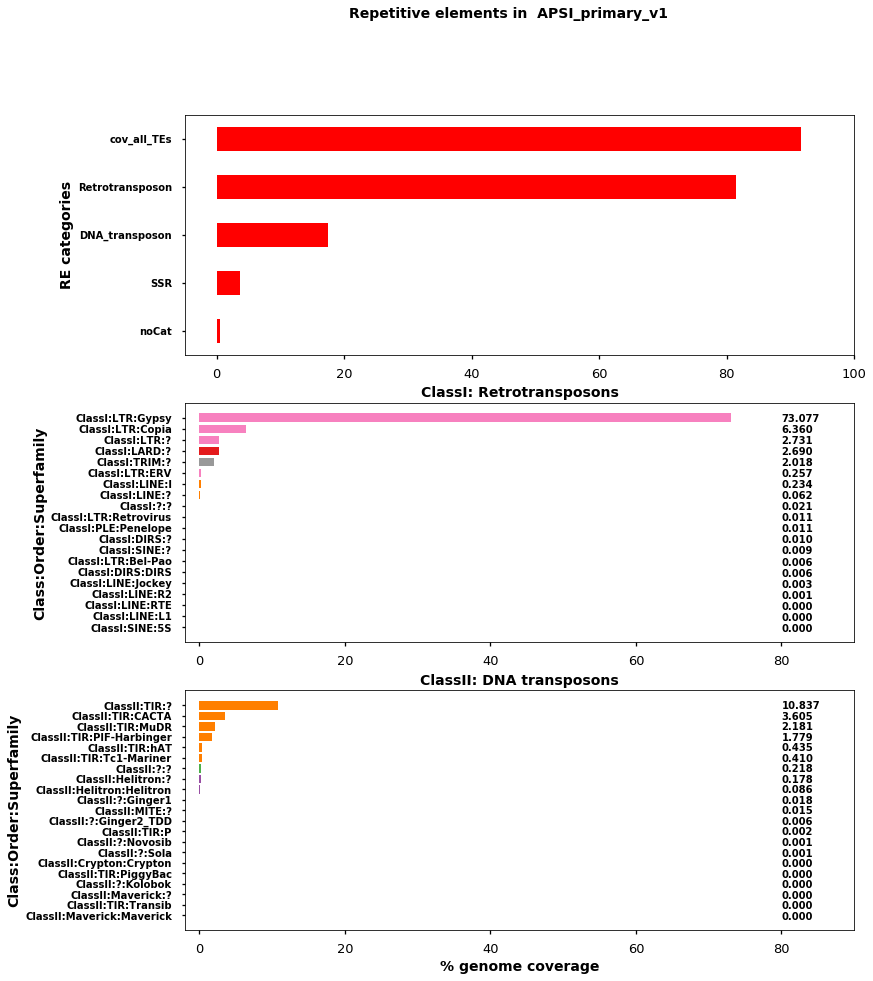

In [131]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in  %s" % genome, fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.sort_values(['%'], inplace=True)
cov_per_class_df.plot(kind='barh', y='%', ax=ax0,  color='r')
ax0.set_xlim([-5,100])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%',\
                                                            ascending=True)
classI_df.drop('Retrotransposon', inplace = True)
#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
ax1.barh(np.arange(len(classI_df.index)), classI_df['%'],
        color=classI_df['Color'], ecolor='black')
ax1.set_yticks(np.arange(len(classI_df.index)))
ax1.set_xlim([-2,90])
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['%']):
    ax1.annotate('{0:.3f}'.format(value), (80,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%',\
                                                                                        ascending=True)
classII_df.drop('DNA_transposon', inplace = True)

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out

ax2.barh(np.arange(len(classII_df.index)), classII_df['%'],
        color=classII_df['Color'], ecolor='black')

ax2.set_xlim([-2, 90])
ax2.set_yticks(np.arange(len(classII_df.index)))

ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('% genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['%']):
    ax2.annotate('{0:.3f}'.format(value), (80 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

    
##OUTPATH for figures
   
#fig.savefig(os.path.join(out_dir, genome+'.REPET_summary_pc.seaborn-talk.png'), dpi=600, bbox_inches="tight")
outfn = os.path.join(OUTPATH, genome+'.REPET_summary_pc.seaborn-talk.tiff')
#fig.savefig(outfn, dpi=600, bbox_inches="tight")

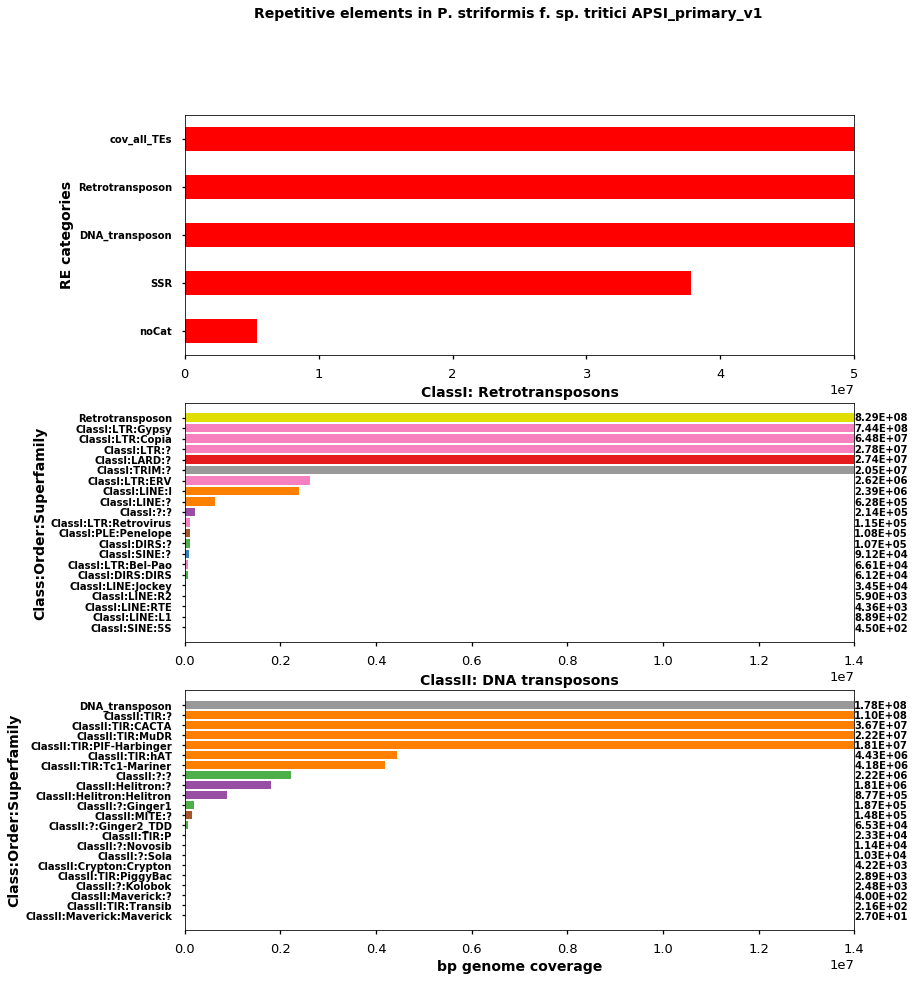

In [132]:
plt.style.use('seaborn-talk')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(12,15))
fig.suptitle("Repetitive elements in P. striformis f. sp. tritici %s" % genome, fontsize=14, fontweight = 'bold')

#color cycle from color blind people 
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
'#999999', '#e41a1c', '#dede00']

#plot the overall genome coverage by repetitive element category
cov_per_class_df.plot(kind='barh', y='bp', ax=ax0,  color='r')
ax0.set_xlim([-5,50000000])
ax0.legend().set_visible(False)
ax0.set_yticklabels(list(cov_per_class_df.index),fontsize=10, fontweight='bold')
ax0.set_ylabel(ylabel='RE categories', fontsize=14, fontweight='bold')

#plot class I 
classI_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'Retrotransposon'].sort_values('%',\
                                                            ascending=True)
#pick out the colors to do color matching on the order level
tmp_cn = len(classI_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classI_df['Order'].unique(), tmp_colors))
classI_df['Color'] = classI_df['Order'].apply(lambda x: tmp_col_dict[x])
ax1.barh(np.arange(len(classI_df.index)), classI_df['bp'],
        color=classI_df['Color'], ecolor='black')
ax1.set_yticks(np.arange(len(classI_df.index)))
ax1.set_xlim([-2,14000000])
ax1.set_yticklabels(list(classI_df.index),fontsize=10, fontweight='bold')
ax1.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax1.set_title('ClassI: Retrotransposons', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax1.patches, classI_df['bp']):
    ax1.annotate('{0:.2E}'.format(value), (14000000,p.get_y() * 1.005),fontsize=10, fontweight='bold' )

#plot class II
classII_df = cov_per_superfamily_df[cov_per_superfamily_df['Class'] == 'DNA_transposon'].sort_values('%',\
                                                                                        ascending=True)

#pick out the colors to do color matching on the order level
tmp_cn = len(classII_df['Order'].unique())
tmp_colors = CB_color_cycle[0:tmp_cn]
tmp_col_dict = dict(zip(classII_df['Order'].unique(), tmp_colors))
classII_df['Color'] = classII_df['Order'].apply(lambda x: tmp_col_dict[x])

#plot the class II out

ax2.barh(np.arange(len(classII_df.index)), classII_df['bp'],
        color=classII_df['Color'], ecolor='black')

ax2.set_xlim([-2,14000000])
ax2.set_yticks(np.arange(len(classII_df.index)))

ax2.set_yticklabels(list(classII_df.index),fontsize=10, fontweight='bold')
ax2.set_ylabel(ylabel='Class:Order:Superfamily', fontsize=14, fontweight='bold')
ax2.set_title('ClassII: DNA transposons', fontsize=14, fontweight='bold')
ax2.set_xlabel('bp genome coverage', fontsize=14, fontweight='bold')

#add tick lables

for p, value in zip(ax2.patches, classII_df['bp']):
    ax2.annotate('{0:.2E}'.format(value), (14000000 ,p.get_y() * 1.005),fontsize=10, fontweight='bold' )
    
fig.savefig(os.path.join(out_dir, genome+'.REPET_summary_bpcov.seaborn-talk.png'), dpi=600, bbox_inches="tight")

outfn = os.path.join(OUTPATH, genome+'.REPET_summary_bpcov.seaborn-talk.tiff')
fig.savefig(outfn, dpi=600, bbox_inches="tight")

### Now some analysis of the divergence of the TEs

In [133]:
#now get the summary of allTEs == TEs specificaly identified by TEdenovo from REPET
REPET_denovoTEs_df = pd.read_csv(\
        os.path.join(TE_postanalysis_dir, '%s_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' % genome_repet),\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRx TEs == TEs identified by repbase20.05_ntSeq_cleaned_TE
REPET_nt_repbase_df = pd.read_csv(\
    os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRx_path.annotStatsPerTE.tab' % genome_repet) ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRtx TEs == TEs identified by repbase20.05_aaSeq_cleaned_TE
REPET_aa_repbase_df = pd.read_csv(\
    os.path.join(TE_postanalysis_dir, '%s_chr_bankBLRtx_path.annotStatsPerTE.tab' % genome_repet) ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )


In [134]:
#generate a df that contains all TEs: TEdenovo, blastx, blastn
REPET_all_TEs_df = pd.concat([REPET_denovoTEs_df ,REPET_nt_repbase_df,\
                                       REPET_aa_repbase_df], axis=0)

In [135]:
REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 0]
REPET_all_TEs_df = REPET_all_TEs_df[~REPET_all_TEs_df.TE.str.startswith("Potential")]

In [137]:
#update the TE_COS_dict with missing values that come mostly from blastx and blastn searches.
missing_TE_keys = list(set(REPET_all_TEs_df.TE.unique())- set(TE_COS_dict.keys()))
missing_TE_values  = [x[x.find(':')+1:] for x in missing_TE_keys]
TE_COS_dict.update(dict(zip(missing_TE_keys ,missing_TE_values )))

In [138]:
#get the Class/order/superfamily column to the dataframe based on the TE_COS_dict
REPET_all_TEs_df["COS"] = REPET_all_TEs_df["TE"].apply(lambda x: TE_COS_dict[x])

In [139]:
#using the formula T=D/t in arXiv:1209.0176 [q-bio] to approximate TE age
# where D = (100-meanId)/100 and 
# t the substitution rate per site per year
# generations per year are estimate at 15 10.1111/j.1365-294X.2007.03513.x
# estimate of subsitution rate per year = 2 * 10-9 10.1093/oxfordjournals.molbev.a004056 and
# 10.1016/j.fbr.2010.03.001
REPET_all_TEs_df['TE_age_Mya'] = (((100-REPET_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))/10**6
REPET_all_TEs_df['TE_age'] = (((100-REPET_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))
REPET_all_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.copies > 5]


In [140]:
REPET_ClassI_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.COS.str.startswith('ClassI:')]
REPET_ClassII_TEs_df = REPET_all_TEs_df[REPET_all_TEs_df.COS.str.startswith('ClassII:')]

In [141]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


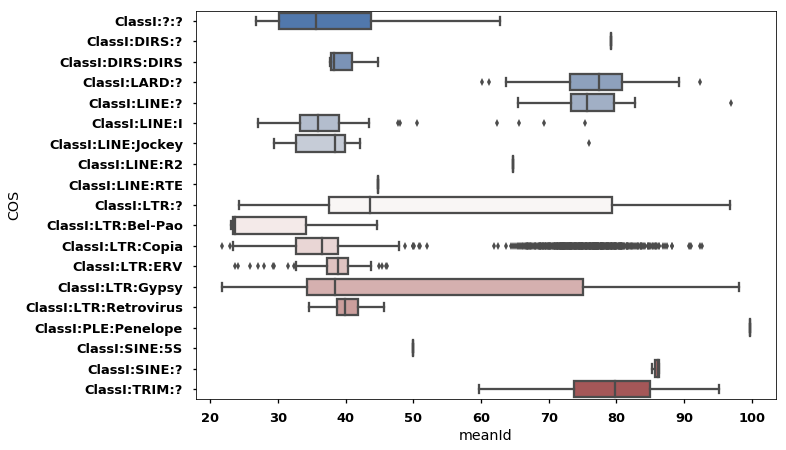

In [142]:
REPET_ClassI_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='meanId', y='COS', data=REPET_ClassI_TEs_df,palette="vlag")

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


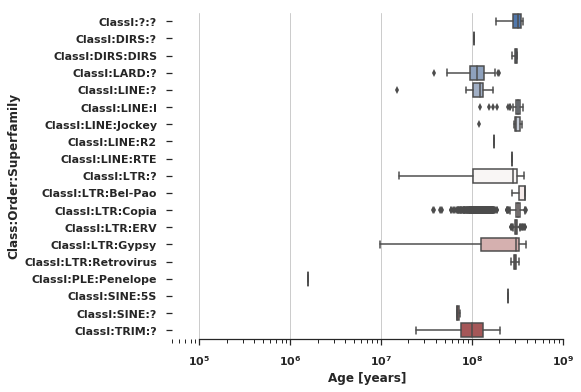

In [143]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassI_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassI_TEs_df,palette="vlag")

plt.xlim(5*10**4, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassI_age.png' % (genome, Tenovodb))

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


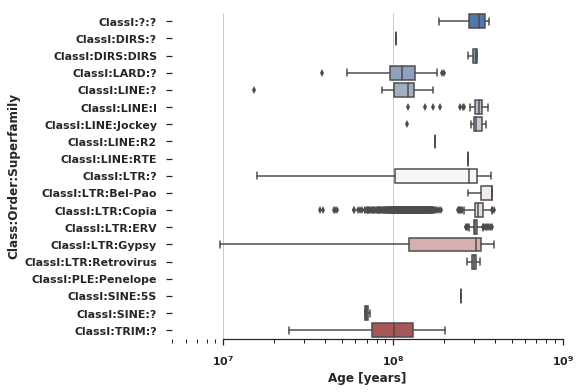

In [144]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassI_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassI_TEs_df,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassI_age.png' % (genome, Tenovodb))
#f.savefig(out_fn, dpi=600,bbox_inches="tight")



/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


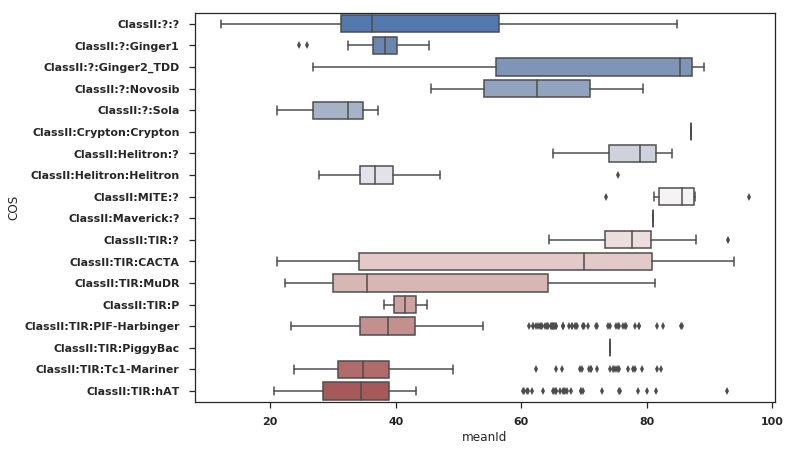

In [145]:
REPET_ClassII_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='meanId', y='COS', data=REPET_ClassII_TEs_df,palette="vlag")

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


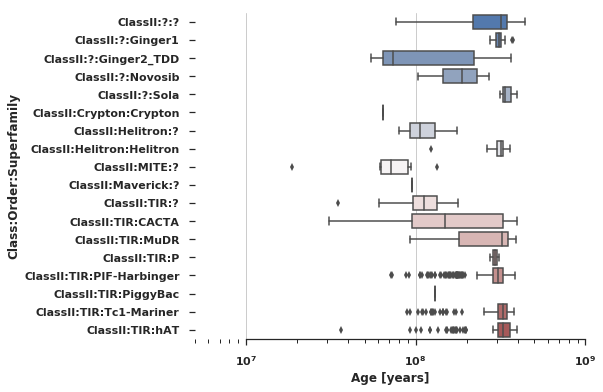

In [146]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassII_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassII_TEs_df,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassII_age.png' % (genome, Tenovodb))
#f.savefig(out_fn, dpi=600,bbox_inches="tight")


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


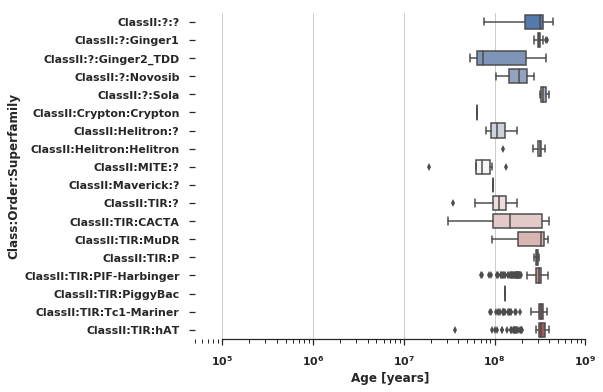

In [147]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

REPET_ClassII_TEs_df.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=REPET_ClassII_TEs_df,palette="vlag")

plt.xlim(5*10**4, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, '%s_%s_ClassII_age.png' % (genome, Tenovodb))

In [148]:
sub_df_young_many = REPET_all_TEs_df[(REPET_all_TEs_df.copies > 50) &( REPET_all_TEs_df.meanId > 75)]

sub_df_young_many_by_COS_sum = sub_df_young_many.groupby('COS').sum()

sub_df_young_many_by_COS_sum['Class'] = 'noCat'
sub_df_young_many_by_COS_sum["Index"] = sub_df_young_many_by_COS_sum.index
sub_df_young_many_by_COS_sum['Order'] = 'noCat'
sub_df_young_many_by_COS_sum['Class:Order'] = 'noCat'

#generate Class column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[0])

#generate Order column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[1])


#generate Class order column
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class:Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Class']\
+ ':' +\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Order']

In [149]:
#get color column sorted
colors = sns.color_palette('cubehelix', n_colors=\
                           len(sub_df_young_many_by_COS_sum['Class:Order'].unique()))
color_dict = dict(zip(sub_df_young_many_by_COS_sum['Class:Order'].unique(), colors))

In [150]:
sub_df_young_many_by_COS_sum['color'] = sub_df_young_many_by_COS_sum['Class:Order'].apply(\
        lambda x: color_dict[x])
color_index_dict = dict(zip(sub_df_young_many_by_COS_sum.Index, sub_df_young_many_by_COS_sum.color))

No handles with labels found to put in legend.
/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


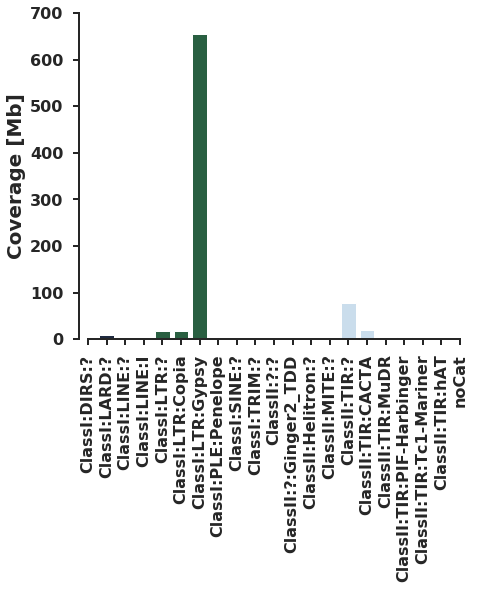

In [151]:
sns.set(style="ticks")
#sns.set_style("whitegrid")
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
sns.barplot(sub_df_young_many_by_COS_sum.index, sub_df_young_many_by_COS_sum.covg/10**6,\
           palette=color_index_dict)
plt.ylim(0, 700)
plt.ylabel("Coverage [Mb]",**font)
plt.xlabel("",**font)
sns.despine(trim=True)

#change the colors of the legend
key_list = list(color_dict.keys())
key_list.sort()
plt.legend(key_list, loc=(1, 0.1))
leg = ax.get_legend()
for (x,y) in zip(key_list, leg.legendHandles):
    y.set_color(color_dict[x])
    


for l in ax.get_xticklabels():
    l.set_rotation(90)
    l.set_fontsize(16)
for l in ax.get_yticklabels():
    l.set_fontsize(16)
    
plt.legend(frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)    
    
out_fn = os.path.join(OUTPATH, 'SF2C_%s_%s_TEs_young_and_plenty.tiff'  % (genome, Tenovodb))
#f.savefig(out_fn, dpi=600, bbox_inches="tight")

In [152]:
sub_df_young_many_by_COS_sum.head()

,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,q25Id,...,medLgthPerc,q75LgthPerc,maxLgthPerc,TE_age_Mya,TE_age,Class,Index,Order,Class:Order,color
COS,,,,,,,,,,,,,,,,,,,,,
ClassI:DIRS:?,13536,83829,103,0,79,0,79.17,10.75,57.90,71.29,...,2.31,13.02,82.97,104.15,1.041500e+08,ClassI,ClassI:DIRS:?,DIRS,ClassI:DIRS,"(0.0904737111999, 0.0544571611023, 0.138527485..."
ClassI:LARD:?,377903,8687447,14251,68,11567,92,3975.00,482.87,2939.32,3618.22,...,334.21,667.26,3543.41,5125.00,5.125000e+09,ClassI,ClassI:LARD:?,LARD,ClassI:LARD,"(0.0996972083269, 0.158015547506, 0.270935085981)"
ClassI:LINE:?,25562,430328,395,21,366,23,232.26,34.23,175.20,203.69,...,27.56,60.59,388.35,338.70,3.387000e+08,ClassI,ClassI:LINE:?,LINE,ClassI:LINE,"(0.0821736071033, 0.293382858441, 0.305676989012)"
ClassI:LINE:I,4068,26757,77,0,73,0,75.41,12.85,55.40,64.40,...,5.43,21.63,24.66,122.95,1.229500e+08,ClassI,ClassI:LINE:I,LINE,ClassI:LINE,"(0.0821736071033, 0.293382858441, 0.305676989012)"
ClassI:LTR:?,342308,16787285,14276,29,11259,30,1510.20,192.72,1082.89,1364.29,...,102.00,261.57,1706.85,1949.00,1.949000e+09,ClassI,ClassI:LTR:?,LTR,ClassI:LTR,"(0.127355620966, 0.406881075409, 0.251050972013)"


In [153]:
sub_df_young_many.head()

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,meanLgthPerc,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age_Mya,TE_age
1,DHX-incomp-chim_Blc36_MR_P2A_300Mb-L-B58-Map1_...,24248,465770,807,1,657,1,77.04,8.95,55.5,...,2.93,5.61,0.08,0.36,1.22,4.50,100.00,ClassII:Helitron:?,114.80,114800000.0
2,DHX-incomp-chim_Blc562_MR_P2A_300Mb-L-B575-Map...,16682,200619,176,1,138,1,80.70,10.14,58.7,...,8.72,13.93,0.13,0.86,3.27,10.38,100.00,ClassII:Helitron:?,96.50,96500000.0
9,DTX-comp_Blc3603_MR_P2A_300Mb-B-P275.0-Map3_re...,6203,2052232,1284,50,1052,58,78.07,9.57,55.8,...,31.46,26.47,0.34,10.51,24.83,48.35,103.53,ClassII:TIR:PIF-Harbinger,109.65,109650000.0
10,DTX-comp_Blc3621_MR_P2A_300Mb-B-P261.0-Map8,6020,388170,195,23,166,27,81.64,13.37,55.1,...,38.86,36.52,0.37,5.40,28.19,59.57,100.76,ClassII:TIR:PIF-Harbinger,91.80,91800000.0
12,DTX-comp_Blc3635_MR_P2A_300Mb-B-P160.0-Map3,5816,140544,112,9,103,9,78.81,15.96,55.3,...,23.46,30.48,0.38,1.81,7.36,36.23,99.83,ClassII:TIR:PIF-Harbinger,105.95,105950000.0


In [154]:
young_cov_TE = sub_df_young_many[sub_df_young_many.meanId > 75].groupby('TE')['covg'].sum()

In [155]:
young_cov_TE.sort_values()

TE
RLX-comp_Blc1_MR_P2A_300Mb-L-B3088-Map1                             4661
RLX-incomp_Blc3417_MR_P2A_300Mb-L-B4704-Map1                        4844
RXX-LARD_Blc4280_MR_P2A_300Mb-L-B5713-Map1                          5052
RLX-incomp_Blc3410_MR_P2A_300Mb-L-B4698-Map1                        5095
RLX-incomp-chim_Blc825_MR_P2A_300Mb-B-P21.0-Map20_reversed          5176
RLX-incomp_Blc2396_MR_P2A_300Mb-L-B3105-Map1_reversed               5603
RLX-comp_Blc3422_MR_P2A_300Mb-L-B4709-Map1                          5931
RXX-LARD_Blc4329_MR_P2A_300Mb-L-B5771-Map1                          6296
RXX-LARD_Blc4192_MR_P2A_300Mb-L-B5617-Map1                          6326
RLX-incomp_Blc2577_MR_P2A_300Mb-L-B3428-Map1                        7192
RLX-comp_Blc1495_MR_P2A_300Mb-L-B1493-Map1_reversed                 7212
RXX-TRIM_Blc4296_MR_P2A_300Mb-L-B5727-Map1                          7307
RXX-LARD_Blc4159_MR_P2A_300Mb-L-B5576-Map1                          8109
RLX-incomp_Blc1342_MR_P2A_300Mb-L-B1338-Map1_rev

In [208]:
#reusing above
sub_df_young_many = REPET_all_TEs_df[(REPET_all_TEs_df.copies > 10) &( REPET_all_TEs_df.meanId > 10)]

sub_df_young_many_by_COS_sum = sub_df_young_many.groupby('COS').sum()

sub_df_young_many_by_COS_sum['Class'] = 'noCat'
sub_df_young_many_by_COS_sum["Index"] = sub_df_young_many_by_COS_sum.index
sub_df_young_many_by_COS_sum['Order'] = 'noCat'
sub_df_young_many_by_COS_sum['Class:Order'] = 'noCat'

#generate Class column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[0])

#generate Order column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[1])


#generate Class order column
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class:Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Class']\
+ ':' +\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Order']

In [213]:
sub_df_young_many.head()

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age_Mya,TE_age,Intervals
0,DHX-incomp-chim_Blc1018_MR_P2A_300Mb-L-B1021-Map1,11814,458217,342,1,217,1,65.07,10.19,54.4,...,18.50,0.19,4.41,10.34,31.27,100.00,ClassII:Helitron:?,174.65,174650000.0,"(65, 66]"
1,DHX-incomp-chim_Blc36_MR_P2A_300Mb-L-B58-Map1_...,24248,465770,807,1,657,1,77.04,8.95,55.5,...,5.61,0.08,0.36,1.22,4.50,100.00,ClassII:Helitron:?,114.80,114800000.0,"(77, 78]"
2,DHX-incomp-chim_Blc562_MR_P2A_300Mb-L-B575-Map...,16682,200619,176,1,138,1,80.70,10.14,58.7,...,13.93,0.13,0.86,3.27,10.38,100.00,ClassII:Helitron:?,96.50,96500000.0,"(80, 81]"
3,DHX-incomp_Blc4656_MR_P2A_100Mb_RS_775,158,5848,40,29,40,29,84.08,7.07,72.9,...,13.54,43.04,94.30,99.37,100.00,100.63,ClassII:Helitron:?,79.60,79600000.0,"(84, 85]"
4,DMX-incomp-chim_Blc907_MR_P2A_300Mb-L-B29-Map2,12548,459,11,0,11,0,80.95,8.03,66.2,...,0.23,0.19,0.23,0.29,0.47,0.98,ClassII:Maverick:?,95.25,95250000.0,"(80, 81]"


In [214]:
intervals = pd.interval_range(start=20, end=100, closed='right', periods=80)
sub_df_young_many['Intervals'] = pd.cut(sub_df_young_many.meanId, intervals)

grouped = sub_df_young_many.groupby(['COS','Intervals'])
sum_df = grouped.agg({'meanId': 'mean', 'covg': 'sum'})
#sum_df['Interval_edge'] = intervals.right
sum_df['freq_covg'] = sum_df.covg / sum_df.covg.sum()
#sum_df["re_cumsum_covg"] = sum_df.sort_values('Interval_edge', ascending='False')['covg'].cumsum()

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [215]:
sum_freq_covg_df = sum_df.unstack()['freq_covg'].T
sum_freq_covg_df['Interval_edge'] = [x.right for x in sum_freq_covg_df.index]

In [216]:
#sum_freq_covg_df.drop('RLX-incomp_Blc2748_MR_P2A_300Mb-L-B3707-Map1', axis=1, inplace=True)
sum_freq_covg_df.sort_values('Interval_edge', inplace=True)

In [217]:
column_filter = sum_freq_covg_df.sum()*100 > 0.5

In [223]:
column_filter.index

Index(['ClassI:?:?', 'ClassI:DIRS:?', 'ClassI:DIRS:DIRS', 'ClassI:LARD:?',
       'ClassI:LINE:?', 'ClassI:LINE:I', 'ClassI:LINE:Jockey',
       'ClassI:LINE:R2', 'ClassI:LTR:?', 'ClassI:LTR:Bel-Pao',
       'ClassI:LTR:Copia', 'ClassI:LTR:ERV', 'ClassI:LTR:Gypsy',
       'ClassI:LTR:Retrovirus', 'ClassI:PLE:Penelope', 'ClassI:SINE:5S',
       'ClassI:SINE:?', 'ClassI:TRIM:?', 'ClassII:?:?', 'ClassII:?:Ginger1',
       'ClassII:?:Ginger2_TDD', 'ClassII:?:Novosib', 'ClassII:?:Sola',
       'ClassII:Helitron:?', 'ClassII:Helitron:Helitron', 'ClassII:MITE:?',
       'ClassII:Maverick:?', 'ClassII:TIR:?', 'ClassII:TIR:CACTA',
       'ClassII:TIR:MuDR', 'ClassII:TIR:P', 'ClassII:TIR:PIF-Harbinger',
       'ClassII:TIR:PiggyBac', 'ClassII:TIR:Tc1-Mariner', 'ClassII:TIR:hAT',
       'RLX-incomp_Blc2748_MR_P2A_300Mb-L-B3707-Map1', 'noCat',
       'Interval_edge'],
      dtype='object', name='COS')

In [219]:
from scipy.interpolate import interp1d

In [220]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


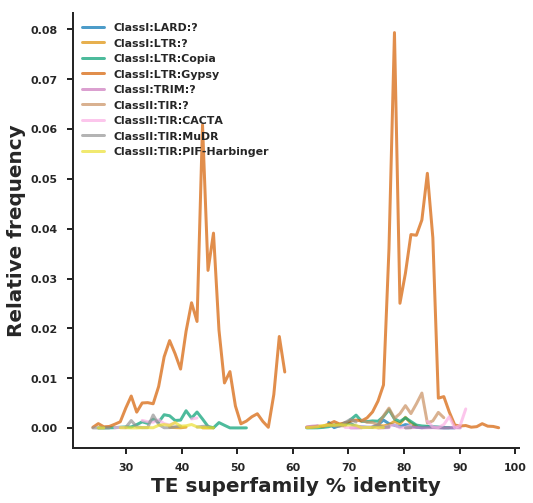

In [221]:
f, ax = plt.subplots(figsize=(8,8))

df = sum_freq_covg_df#.loc[:, column_filter]

superfamilies = [x for x in sum_freq_covg_df.loc[:, column_filter].columns if not x == 'Interval_edge']

col_n = len(sum_freq_covg_df.loc[:, column_filter].columns)

pallete = sns.color_palette('colorblind')


for sf, color in zip(superfamilies, pallete):
    x, y = df['Interval_edge'], df[sf]
    f2 = interp1d(x, y)
    xnew = np.linspace(x.min(), x.max(), num=80, endpoint=True)
    ax.plot(xnew, f2(xnew), '-', color=color, label = sf,  linewidth=3, alpha = 0.7)
ax.legend()
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('TE superfamily % identity', **font)
#outfn = os.path.join(OUTPATH, 'SF2A_TE_variation.tiff')
plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)

In [198]:
intervals = pd.interval_range(start=20, end=100, closed='right', periods=80)
sub_df_young_many['Intervals'] = pd.cut(sub_df_young_many.meanId, intervals)

grouped = sub_df_young_many.groupby(['TE','Intervals'])
sum_df = grouped.agg({'meanId': 'mean', 'covg': 'sum'})
#sum_df['Interval_edge'] = intervals.right
sum_df['freq_covg'] = sum_df.covg / sum_df.covg.sum()
#sum_df["re_cumsum_covg"] = sum_df.sort_values('Interval_edge', ascending='False')['covg'].cumsum()
sum_freq_covg_df = sum_df.unstack()['freq_covg'].T
sum_freq_covg_df['Interval_edge'] = [x.right for x in sum_freq_covg_df.index]
sum_freq_covg_df.sort_values('Interval_edge', inplace=True)

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [199]:
column_filter = sum_freq_covg_df.sum()*100 > 0.1

In [201]:
sub_df_young_many[sub_df_young_many.TE == 'RLX-incomp-chim_Blc22_MR_P2A_300Mb-L-B1-Map20_reversed']

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age_Mya,TE_age,Intervals
1703,RLX-incomp-chim_Blc22_MR_P2A_300Mb-L-B1-Map20_...,120268,144512997,77731,0,41819,0,77.23,9.89,55.2,...,3.09,0.02,0.8,1.57,4.18,25.9,ClassI:LTR:Gypsy,113.85,113850000.0,"(77, 78]"


In [203]:
from matplotlib.lines import Line2D

In [204]:
legend_elements = []
for x, y in color_dict.items():
    legend_elements.append(Line2D([0], [0], marker='o', color=y, label=x,
                          markerfacecolor=y, markersize=10, lw=0))

(15, 105)

/home/benjamin/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


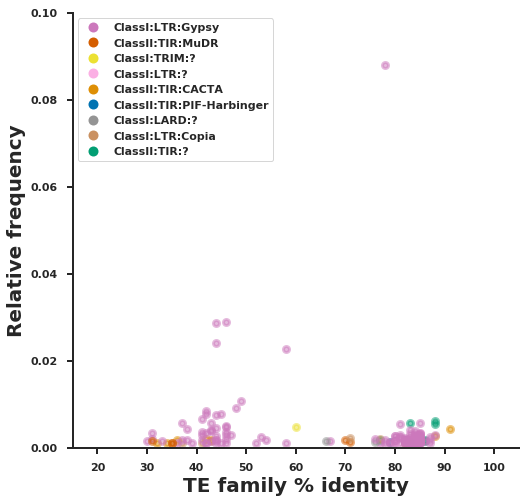

In [206]:
#color code dots by TE COS
f, ax = plt.subplots(figsize=(8,8))

df = sum_freq_covg_df.loc[:, column_filter]

superfamilies = [x for x in sum_freq_covg_df.loc[:, column_filter].columns if not x == 'Interval_edge']

col_n = len(sum_freq_covg_df.loc[:, column_filter].columns)


color_dict = {}
cmap = get_cmap(col_n)
for n, x in enumerate(sub_df_young_many[sub_df_young_many.TE.isin(superfamilies)]['COS'].unique()):
    color_dict[x] = sns.color_palette('colorblind')[n]
    


pallete = sns.color_palette('colorblind')

df.fillna(0)

for sf in superfamilies:
    x, y = df['Interval_edge'], df[sf]
    #f2 = interp1d(x, y)
    #xnew = np.linspace(x.min(), x.max(), num=80, endpoint=True)
    ax.scatter(x, y, label = sf, color=color_dict[sub_df_young_many[sub_df_young_many.TE == sf]['COS'].tolist()[0]], linewidth=3, alpha = 0.5)
ax.legend(handles=legend_elements, loc='best')
ax.set_ylabel('Relative frequency', **font)
ax.set_xlabel('TE family % identity', **font)
#outfn = os.path.join(OUTPATH, 'SF2A_TE_variation.tiff')
#plt.legend(loc='upper left', frameon=False)
#['top','bottom','left','right']
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.tick_params(width=2)
ax.set_ylim(0, 0.1)
ax.set_xlim(15, 105)

### Apologies for the messy coding